In [1]:
# Librerías
import pandas as pd
from sklearn.model_selection import train_test_split
# Warnings
import warnings
warnings.filterwarnings('ignore')
# Internal tool and helpers
import model_helpers as mh
import xgboost as xgb

In [2]:
data_path = "../CHESS/data/df_3_cod.csv"
df_3 = pd.read_csv(data_path)

In [3]:
# X e Y 
X = df_3.copy()
y_name = "winner_cod"
# X es el dataframe eliminando la variable de salida. Eliminando también 'moves' que ya está representado
X = X.drop(columns=['rated','winner',y_name, 'current_turn','time_increment','opening_code','opening_fullname','opening_shortname','opening_variation','moves_fen'])
X = X.drop(columns=['game_id', 'white_rating', 'black_rating', 'moves', 'current_turn_cod', 'opening_moves', 'rated_cod', 'current_turn_cod', 'time_increment_cod', 'opening_code_cod', 'opening_fullname_cod', 'opening_shortname_cod', 'opening_variation_cod', 'moves_fen_cod'])# Y es un array unidimensional (ravel) de la variable de salida
Y = df_3[y_name].ravel()
X.columns

Index(['turns', 'w_ctrld_pawn', 'w_ctrld_knight', 'w_ctrld_bishop',
       'w_ctrld_rook', 'w_ctrld_queen', 'w_ctrld_king', 'w_preassure_points',
       'w_ctrld_diagonals', 'w_ctrld_lines', 'b_ctrld_pawn', 'b_ctrld_knight',
       'b_ctrld_bishop', 'b_ctrld_rook', 'b_ctrld_queen', 'b_ctrld_king',
       'b_preassure_points', 'b_ctrld_diagonals', 'b_ctrld_lines'],
      dtype='object')

In [4]:
# división en train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3)
X_train.columns

Index(['turns', 'w_ctrld_pawn', 'w_ctrld_knight', 'w_ctrld_bishop',
       'w_ctrld_rook', 'w_ctrld_queen', 'w_ctrld_king', 'w_preassure_points',
       'w_ctrld_diagonals', 'w_ctrld_lines', 'b_ctrld_pawn', 'b_ctrld_knight',
       'b_ctrld_bishop', 'b_ctrld_rook', 'b_ctrld_queen', 'b_ctrld_king',
       'b_preassure_points', 'b_ctrld_diagonals', 'b_ctrld_lines'],
      dtype='object')

# XGboost

100%|██████████| 250/250 [02:36<00:00,  1.60trial/s, best loss: -0.9201116343973487]
Best set of hyperparameters:  {'learning_rate': 0.12150219245389758, 'max_depth': 10, 'subsample': 0.7564540401062587}


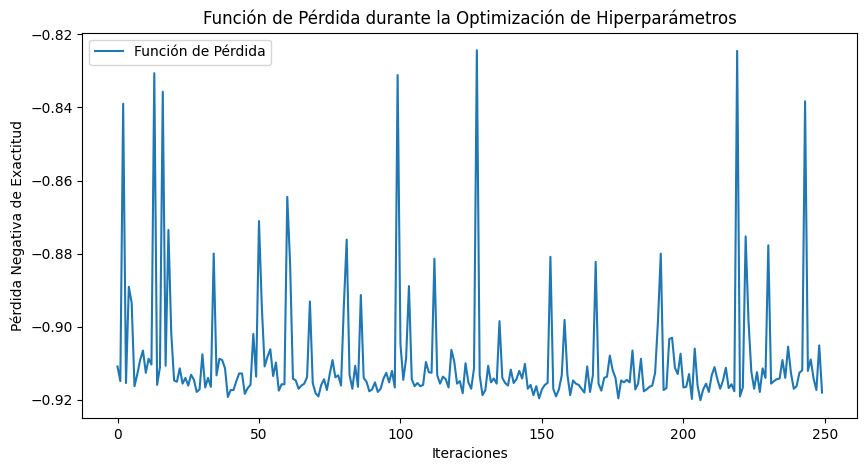

In [12]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Define the hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

# Define the objective function to minimize
def objective(params):
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, Y_train)
    y_pred = xgb_model.predict(X_test)
    score = accuracy_score(Y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=250, trials=trials)
print("Best set of hyperparameters: ", best_params)
# Extraer la función de pérdida de cada resultado en trials
losses = [x['result']['loss'] for x in trials.trials]

# Graficar la función de pérdida
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Función de Pérdida')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida Negativa de Exactitud')
plt.title('Función de Pérdida durante la Optimización de Hiperparámetros')
plt.legend()
plt.show()

In [54]:
# Crear un clasificador XGBoost
xgboost_best = xgb.XGBClassifier(**best_params)
# Entrenar el modelo en los datos de entrenamiento
xgboost_best.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.12150219245389758,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


Performance del modelo de Prueba Xgboost características blancas y negras
 Accu 0.9173207744636316 
 Prec 0.9173328556035396 
 Reca 0.9173207744636316 
 Matriz de confusión:
 [[2503  252]
 [ 222 2756]]

Métricas de Probabilidad:
 Brier Score: 0.05967182200548987


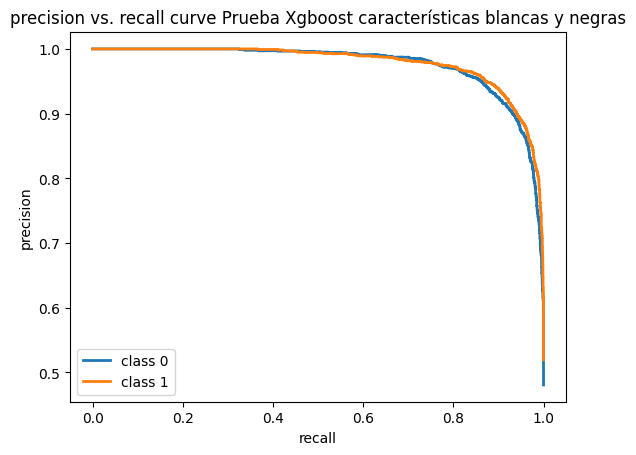

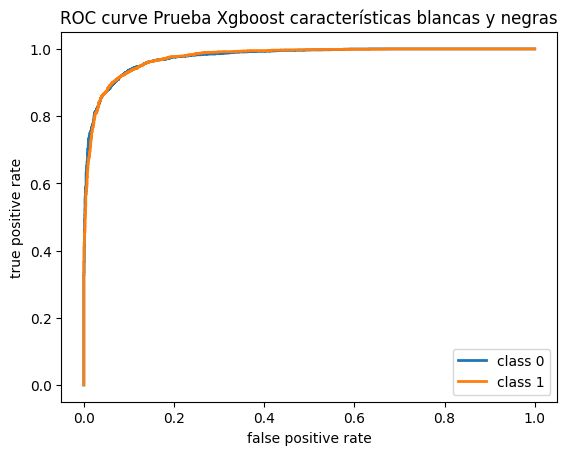


Performance del modelo de Entrenamiento Xgboost características blancas y negras
 Accu 0.9958130841121495 
 Prec 0.9958143069425838 
 Reca 0.9958130841121495 
 Matriz de confusión:
 [[6318   34]
 [  22 7001]]

Métricas de Probabilidad:
 Brier Score: 0.0073737180930116535


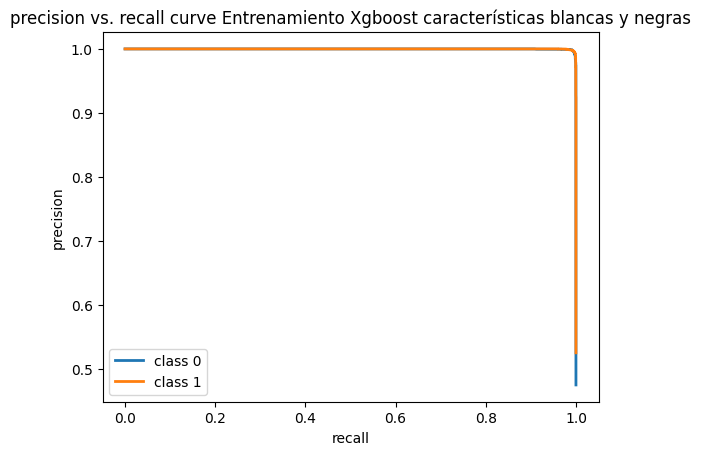

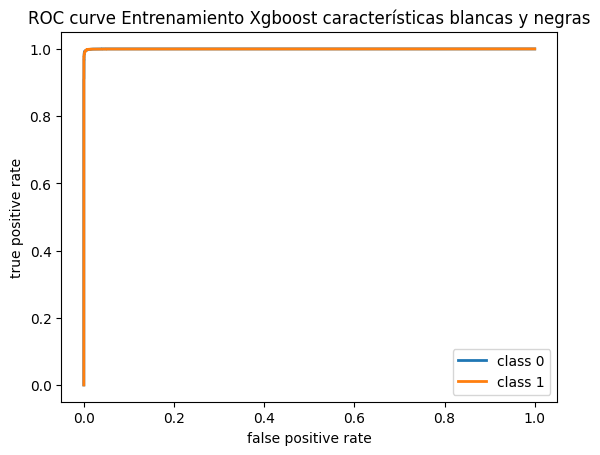

(0.9958130841121495,
 0.9958143069425838,
 0.9958130841121495,
 0.0073737180930116535,
 array([[6318,   34],
        [  22, 7001]], dtype=int64))

In [55]:
Yhat_xgboost_test = xgboost_best.predict(X_test)
Yhat_xgboost_train = xgboost_best.predict(X_train)
Yhat_xgboost_test_prob = xgboost_best.predict_proba(X_test)
Yhat_xgboost_train_prob = xgboost_best.predict_proba(X_train)
mh.eval_perform_multi_class(Y_test,Yhat_xgboost_test, Yhat_xgboost_test_prob,2,"Prueba Xgboost características blancas y negras")
mh.eval_perform_multi_class(Y_train,Yhat_xgboost_train, Yhat_xgboost_train_prob,2,"Entrenamiento Xgboost características blancas y negras")

# XGBOOST Simple

In [59]:
# Crear un clasificador XGBoost
xgboost = xgb.XGBClassifier()
# Entrenar el modelo en los datos de entrenamiento
xgboost.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


Performance del modelo de Prueba Xgboost características blancas y negras
 Accu 0.9162742019884877 
 Prec 0.9162897617196727 
 Reca 0.9162742019884877 
 Matriz de confusión:
 [[2499  256]
 [ 224 2754]]

Métricas de Probabilidad:
 Brier Score: 0.06096106148254271


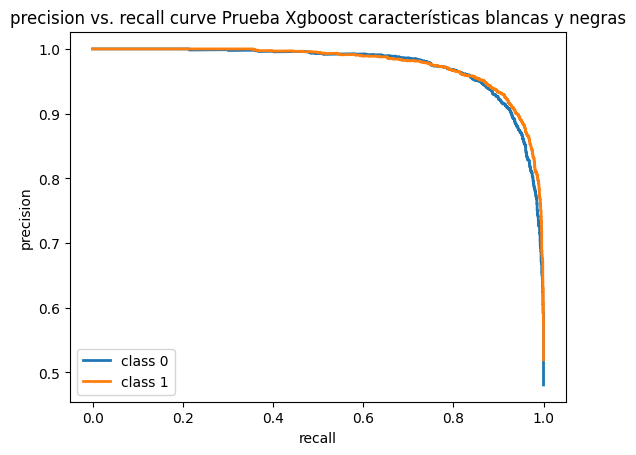

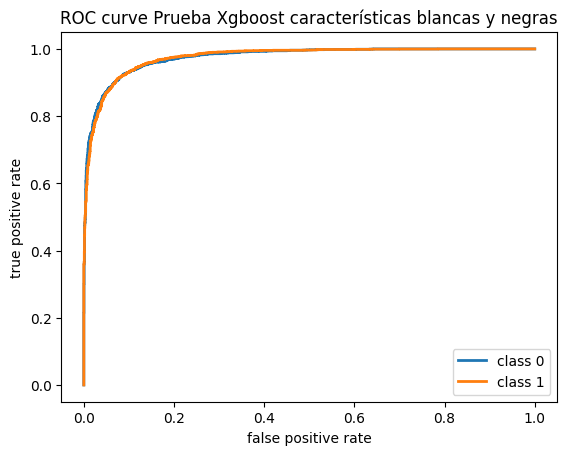


Performance del modelo de Entrenamiento Xgboost características blancas y negras
 Accu 0.9860934579439252 
 Prec 0.9860934579439252 
 Reca 0.9860934579439252 
 Matriz de confusión:
 [[6259   93]
 [  93 6930]]

Métricas de Probabilidad:
 Brier Score: 0.015566782353820129


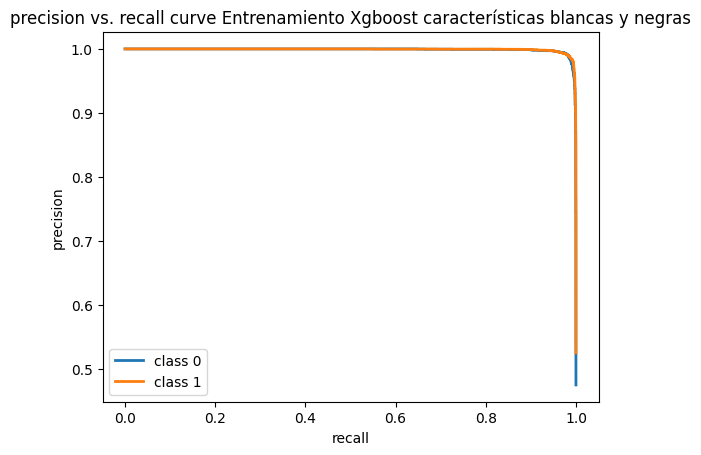

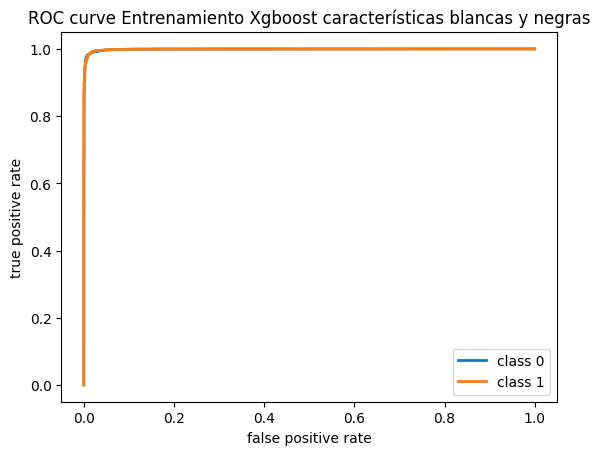

(0.9860934579439252,
 0.9860934579439252,
 0.9860934579439252,
 0.015566782353820129,
 array([[6259,   93],
        [  93, 6930]], dtype=int64))

In [60]:
Yhat_xgboost_test = xgboost.predict(X_test)
Yhat_xgboost_train = xgboost.predict(X_train)
Yhat_xgboost_test_prob = xgboost.predict_proba(X_test)
Yhat_xgboost_train_prob = xgboost.predict_proba(X_train)
mh.eval_perform_multi_class(Y_test,Yhat_xgboost_test, Yhat_xgboost_test_prob,2,"Prueba Xgboost características blancas y negras")
mh.eval_perform_multi_class(Y_train,Yhat_xgboost_train, Yhat_xgboost_train_prob,2,"Entrenamiento Xgboost características blancas y negras")

# Feature Importance

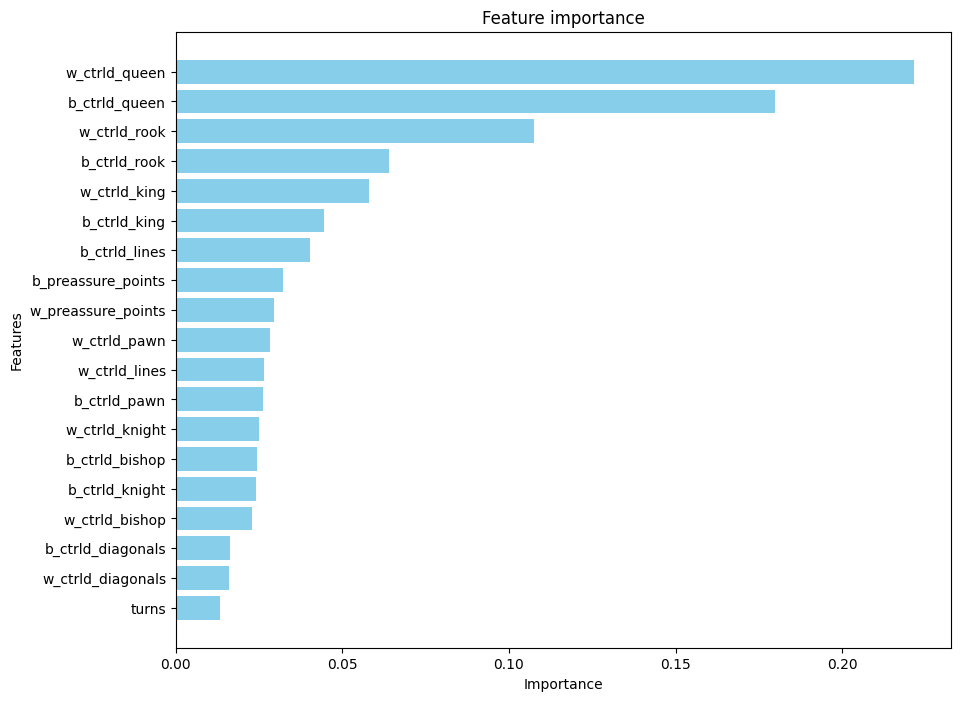

In [61]:
import matplotlib.pyplot as plt
# Feature importance
importance = xgboost.feature_importances_

df_importancia = pd.DataFrame({
    'Caracteristica': X.columns,
    'Importancia': importance
})

umbral = 0
# Filtrar los nombres de las características importantes
df_importancia = df_importancia[df_importancia['Importancia'] > umbral]
df_importancia = df_importancia.sort_values(by='Importancia', ascending=True)

features = df_importancia['Caracteristica']
importance = df_importancia['Importancia']


# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 8))
plt.barh(features, importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature importance')
plt.show()

# Validación del modelo con una muestra de ejemplo

In [62]:
import extract_features as ef
fen = '1r1q1rk1/pb2bppp/4p3/6N1/2pPQ3/4P2P/PP3PP1/R1B2RK1 w - - 1 17'
moves = 4
new_sample_df = ef.count_all_features(fen, moves)
new_sample_df.T

,0
turns,4
w_ctrld_pawn,12
w_ctrld_knight,4
w_ctrld_bishop,1
w_ctrld_rook,3
w_ctrld_queen,15
w_ctrld_king,2
w_preassure_points,7
w_ctrld_diagonals,3
w_ctrld_lines,3


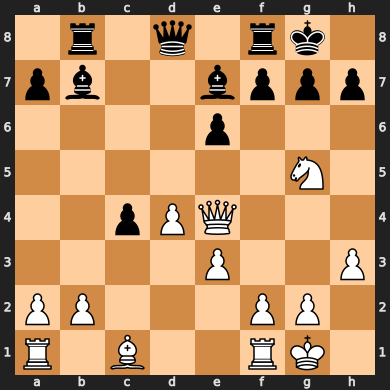

In [64]:
from chess import Board
# Mostrar el tablero de la primera cadena fen
board = Board(fen)
board

In [50]:
print("Posición Blancas: ")
pd.set_option('display.max_columns', None)
ef.get_all_features_uf(fen, True)

Posición Blancas: 


,Total,Caracteristica,Casillas
0,12,Casillas controladas por peon,"['a3', 'b3', 'c3', 'c5', 'd4', 'e3', 'e5', 'f3..."
1,4,Casillas controladas por caballo,"['Nf3', 'Nxe6', 'Nxf7', 'Nxh7']"
2,1,Casillas controladas por alfil,['Bd2']
3,3,Casillas controladas por torre,"['Rb1', 'Rd1', 'Re1']"
4,15,Casillas controladas por reina,"['Qb1', 'Qc2', 'Qc6', 'Qd3', 'Qd5', 'Qe5', 'Qf..."
5,2,Casillas controladas por el rey,"['Kh1', 'Kh2']"
6,7,Puntos de presion (>1 atacando),"['b1', 'e5', 'e6', 'f3', 'f4', 'g4', 'h7']"
7,3,Diagonales controladas,"{'c1': 0, 'e4': 3}"
8,3,Lineas controladas,"{'a1': 0, 'f1': 1, 'e4': 2}"


In [65]:
print("Posición Negras: ")
pd.set_option('display.max_columns', None)
ef.get_all_features_uf(fen, False)

Posición Negras: 


,Total,Caracteristica,Casillas
0,9,Casillas controladas por peon,"['b3', 'b6', 'd3', 'd5', 'e6', 'f5', 'f6', 'g6..."
1,0,Casillas controladas por caballo,[]
2,12,Casillas controladas por alfil,"['Ba3', 'Ba6', 'Ba8', 'Bb4', 'Bc5', 'Bc6', 'Bc..."
3,3,Casillas controladas por torre,"['Ra8', 'Rc8', 'Re8']"
4,9,Casillas controladas por reina,"['Qa5', 'Qb6', 'Qc7', 'Qc8', 'Qd5', 'Qd6', 'Qd..."
5,1,Casillas controladas por el rey,['Kh8']
6,8,Puntos de presion (>1 atacando),"['a8', 'b6', 'c8', 'd5', 'd6', 'e8', 'f6', 'g6']"
7,4,Diagonales controladas,"{'b7': 1, 'e7': 2, 'd8': 1}"
8,1,Lineas controladas,"{'b8': 0, 'f8': 0, 'd8': 1}"


# Decisión del modelo a guardar y usar

In [70]:
prob = xgboost.predict_proba(new_sample_df)
print(xgboost.classes_) # 0: negras. 1: blancas
print(f"Negras: {'{:.6f}'.format(prob[0][0])}. Blancas:{'{:.6f}'.format(prob[0][1])}")


[0 1]
Negras: 0.227277. Blancas:0.772723


In [71]:
prob = xgboost_best.predict_proba(new_sample_df)
print(xgboost_best.classes_) # 0: negras. 1: blancas
print(f"Negras: {'{:.6f}'.format(prob[0][0])}. Blancas:{'{:.6f}'.format(prob[0][1])}")


[0 1]
Negras: 0.221847. Blancas:0.778153


En un entorno de producción tiene menos costo computacional seleccionar el modelo más sencillo para entrenar con nuevos datos, y la variación es despreciable. Por tanto se selecciona ese modelo. 

In [74]:
import pickle
pickle.dump(xgboost, open("./pickles/models/xgoboost_model0416_18:06.pkl", 'wb'))